In [2]:
import numpy as np                              
import pandas as pd                              
import matplotlib.pyplot as plt                  
import seaborn as sns                            

from itertools import product                   
from tqdm import tqdm_notebook

import warnings                                  
warnings.filterwarnings('ignore')

%matplotlib inline

from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import median_absolute_error, mean_squared_error
plt.rcParams["figure.figsize"] = [12, 6]

In [3]:
df_m = pd.read_csv('A:/Data/Metro_Interstate_Traffic_Volume.csv', parse_dates=['date_time'])

In [4]:
df_m.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


#### Оставляю 4 колонки

In [5]:
df = df_m[['traffic_volume', 'date_time', 'holiday', 'temp']].copy()

In [6]:
df.head()

,traffic_volume,date_time,holiday,temp
0,5545,2012-10-02 09:00:00,None,288.28
1,4516,2012-10-02 10:00:00,None,289.36
2,4767,2012-10-02 11:00:00,None,289.58
3,5026,2012-10-02 12:00:00,None,290.13
4,4918,2012-10-02 13:00:00,None,291.14


In [7]:
df.shape

(48204, 4)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   traffic_volume  48204 non-null  int64         
 1   date_time       48204 non-null  datetime64[ns]
 2   holiday         48204 non-null  object        
 3   temp            48204 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.5+ MB


#### Проверю пропуски 

In [9]:
df.isna().sum()

traffic_volume    0
date_time         0
holiday           0
temp              0
dtype: int64

In [10]:
df.describe()

,traffic_volume,temp
count,48204.000000,48204.000000
mean,3259.818355,281.205870
std,1986.860670,13.338232
min,0.000000,0.000000
25%,1193.000000,272.160000
50%,3380.000000,282.450000
75%,4933.000000,291.806000
max,7280.000000,310.070000


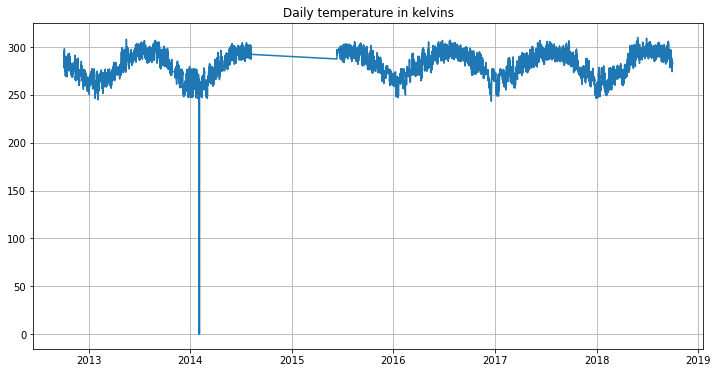

In [11]:

plt.plot(df.date_time, df.temp)
plt.title('Daily temperature in kelvins')
plt.grid(True)
plt.show()

#### Проверю holiday

In [12]:
df.holiday.value_counts()

None                         48143
Labor Day                        7
Christmas Day                    6
Martin Luther King Jr Day        6
New Years Day                    6
Thanksgiving Day                 6
Independence Day                 5
Washingtons Birthday             5
State Fair                       5
Columbus Day                     5
Memorial Day                     5
Veterans Day                     5
Name: holiday, dtype: int64

#### Сделаю переменную holiday бинарной

In [13]:
df["holiday"] = (~(df.holiday =="None")).astype(int)
df.holiday.value_counts()

0    48143
1       61
Name: holiday, dtype: int64

#### Пропуски

In [14]:
df.isna().sum()

traffic_volume    0
date_time         0
holiday           0
temp              0
dtype: int64

#### Посмотрю целевую переменную

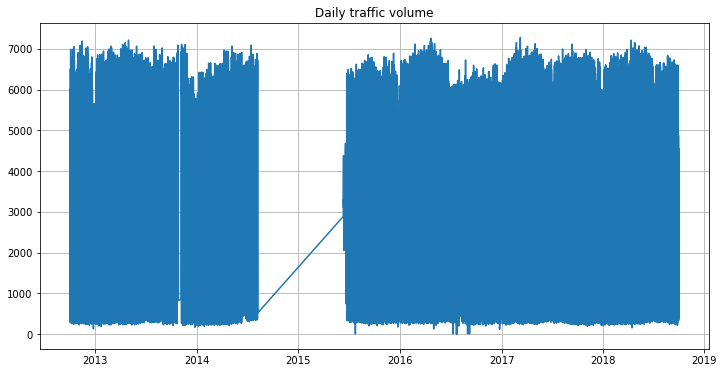

In [15]:
plt.plot(df.date_time, df.traffic_volume)
plt.title('Daily traffic volume')
plt.grid(True)
plt.show()

#### Есть пропуск в данных. Значений достаточно для анализа,поэтому возьму только данные за последние 2 года

In [16]:
df_short = df[df.date_time.dt.year>2016]

In [17]:
df_short.shape

(18554, 4)

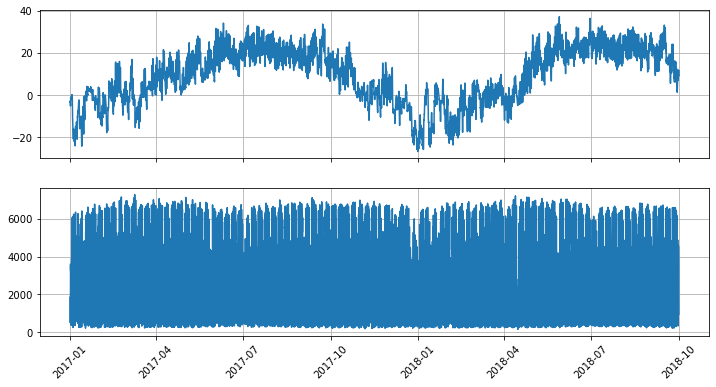

In [18]:
f, (ax1, ax2) = plt.subplots(2,1,sharex=True,figsize=(12, 6))
ax1.plot(df_short.date_time, df_short.temp - 273)
ax1.grid(True)

ax2.plot(df_short.date_time, df_short.traffic_volume)
ax2.grid(True)
plt.xticks( rotation=45);

#### Проверю датафрейм на дубликаты

In [19]:
df_short.duplicated().value_counts()

False    15247
True      3307
dtype: int64

#### Удаляю дубликаты

In [20]:
df_short = df_short.drop_duplicates(subset=["date_time"])
df_short.shape

(15246, 4)

#### Всё в порядке,дубликатов нет,пропущенных значений нет

#### Выравниваю интервалы и интерполирую

In [21]:
df_short.date_time.min()

Timestamp('2017-01-01 00:00:00')

In [22]:
df_short.date_time.max()

Timestamp('2018-09-30 23:00:00')

In [23]:
df_final = \
pd.merge(
    pd.Series(pd.date_range(df_short.date_time.min(), df_short.date_time.max(), freq='h'), name='date_time'),
    df_short,
    how="left",
    on = "date_time"
).interpolate()

In [24]:
df_final['holiday'].value_counts()

0.0    15294
1.0       18
Name: holiday, dtype: int64

In [25]:
df_final.head()

,date_time,traffic_volume,holiday,temp
0,2017-01-01 00:00:00,1848.0,0.0,269.75
1,2017-01-01 01:00:00,1806.0,0.0,269.95
2,2017-01-01 02:00:00,1211.0,0.0,269.75
3,2017-01-01 03:00:00,794.0,0.0,269.65
4,2017-01-01 04:00:00,500.0,0.0,269.48


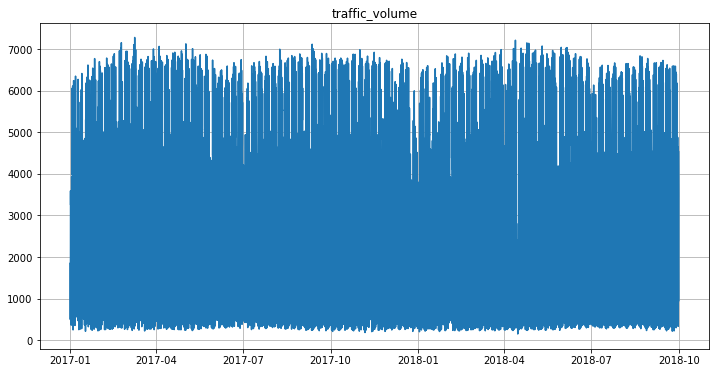

In [26]:
plt.plot(df_final.date_time, df_final.traffic_volume)
plt.title('traffic_volume')
plt.grid(True)
plt.show()

#### Моделирование
#### Создаю дополнительные фичи

In [27]:
df_final.loc[:,"month"] = df_final.date_time.dt.month
df_final.loc[:,"weekday"] = df_final.date_time.dt.dayofweek
df_final.loc[:,"hour"] = df_final.date_time.dt.hour

In [28]:
df_final.head()

,date_time,traffic_volume,holiday,temp,month,weekday,hour
0,2017-01-01 00:00:00,1848.0,0.0,269.75,1,6,0
1,2017-01-01 01:00:00,1806.0,0.0,269.95,1,6,1
2,2017-01-01 02:00:00,1211.0,0.0,269.75,1,6,2
3,2017-01-01 03:00:00,794.0,0.0,269.65,1,6,3
4,2017-01-01 04:00:00,500.0,0.0,269.48,1,6,4


#### Разбиваю на train-test

In [29]:
X_train = df_final.drop(columns="traffic_volume").head(df_final.shape[0]-24*7*2)
y_train = df_final["traffic_volume"].head(df_final.shape[0]-24*7*2)

X_test = df_final.drop(columns="traffic_volume").tail(24*7*2)
y_test = df_final["traffic_volume"].tail(24*7*2)

#### Функция для вывода результатов

In [30]:
from sklearn.metrics import mean_absolute_error
import matplotlib.dates as mdates

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true))

def evaluate(title ,y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label="y_true")
    plt.title('{}. \n MAE - {:.2f}, MAPE - {:.2%}'.format(title, mae, mape))
    plt.plot(y_pred, label="y_pred")
    plt.grid(True)
    plt.legend()
    plt.show()
    

#### Baseline

In [31]:
from sklearn.base import BaseEstimator
class baseline(BaseEstimator):
    def __init__(self, days_limit = None):
        self.model = None
        self.days_limit = days_limit
    def fit(self,X,y):
        if self.days_limit:
            _ = pd.concat([X,y],axis=1).tail(int(self.days_limit)*24)
        else:
            _ = pd.concat([X,y],axis=1)
        self.model = _.groupby(by=["weekday", "hour"]).traffic_volume.mean().to_dict()
    def predict(self, X):
        return X.loc[:, ["weekday", "hour"]].apply(lambda x:self.model.get((x[0],x[1])),axis=1)


In [32]:
bl = baseline()
bl.fit(X_train, y_train)

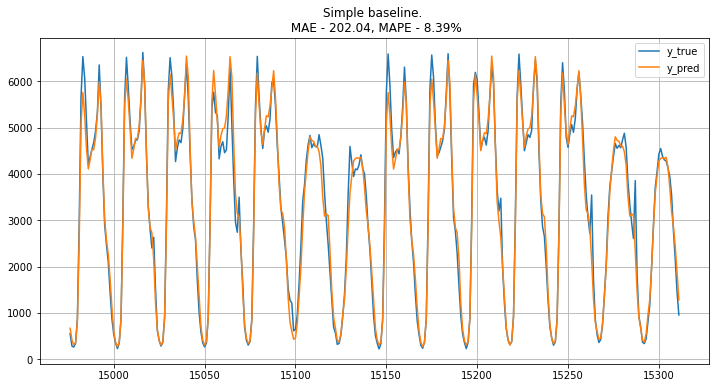

In [33]:
evaluate("Simple baseline", y_test, bl.predict(X_test))

### Модель Хольта-Винтерса

##### Возьму готовый класс из лекции

In [37]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [38]:

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [39]:
%%time
from scipy.optimize import minimize
data = y_train # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_error, 24*7), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

0.006823981457514172 0.000923957601678127 0.0010946562348653766
Wall time: 2min 3s


In [40]:

model = HoltWinters(data, slen = 24*7, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 24*14, scaling_factor = 3)
model.triple_exponential_smoothing()

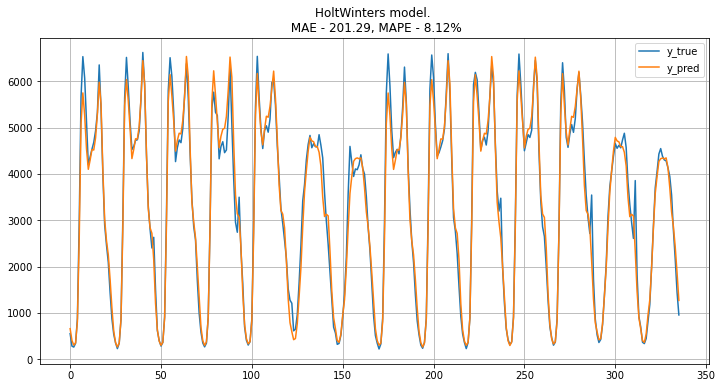

In [41]:
evaluate("HoltWinters model", y_test.values, np.array(model.result[-24*14:]))

#### Модель Хольта-Винтерса сработала лучше, чем Baseline 

### Sarima

In [42]:
import statsmodels.formula.api as smf            
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

#### Опять возьму код из лекции

In [43]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, method="ols")
        plt.tight_layout()

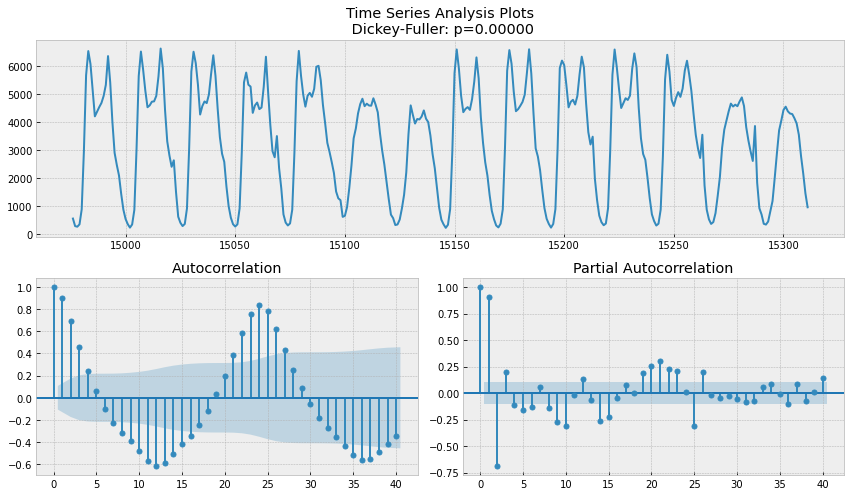

In [44]:
tsplot(y_test, lags=40)

#### тест Дикки-Фуллера говорит, что ряд стационарен

#### вычту сезонность

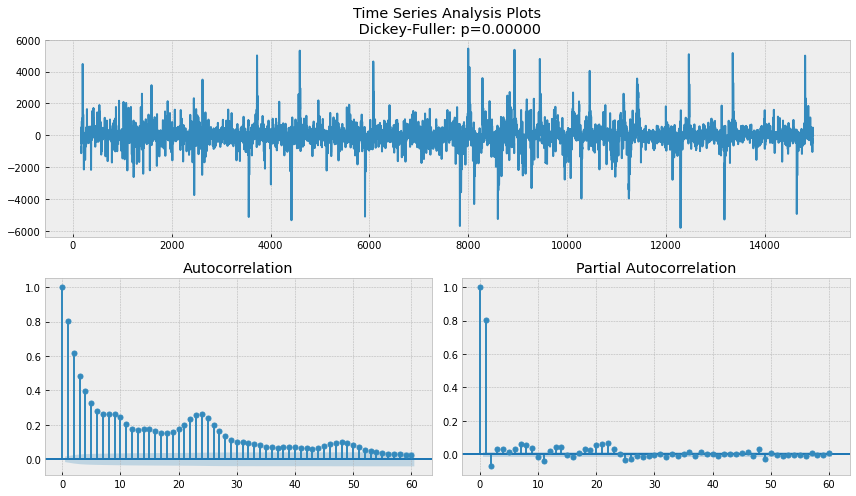

In [45]:
data_diff = y_train - y_train.shift(24*7)
# tsplot(data_diff[24*7:], lags=24*7)
tsplot(data_diff[24*7:], lags=60)

#### вычту ряд сам из себя с шагом 1

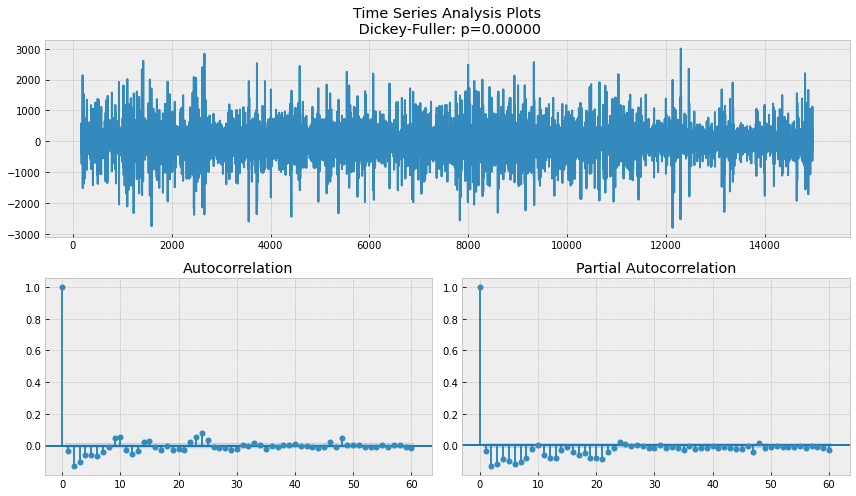

In [46]:
data_diff = data_diff - data_diff.shift(1)

tsplot(data_diff[24*7+1:], lags=60)

#### Дабы сэкономить время,возьму не так много параметров.

In [47]:

ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 24*7 

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [48]:
def optimizeSARIMA(parameters_list, d, D, s):
        
    results = []
    best_aic = float("inf")

    for param in tqdm(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(y_train[-8*24:], order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except Exception as e:
            print(e)
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
    print(results)
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [50]:
%%time

from tqdm.notebook import tqdm
result_table = optimizeSARIMA(parameters_list, d, D, s)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\


[[(2, 2, 0, 0), 328.23503290074706], [(2, 2, 0, 1), 329.1206144020645], [(2, 2, 1, 0), 327.9905711074693], [(2, 2, 1, 1), 332.0471901336124], [(2, 3, 0, 0), 330.2348463356316], [(2, 3, 0, 1), 331.15253181256185], [(2, 3, 1, 0), 330.3385574312395], [(2, 3, 1, 1), 332.04836928687024], [(2, 4, 0, 0), 333.4386316305678], [(2, 4, 0, 1), 333.80308962639], [(2, 4, 1, 0), 332.35002036165884], [(2, 4, 1, 1), 334.3574759483612], [(3, 2, 0, 0), 330.2351515216699], [(3, 2, 0, 1), 331.1353725265569], [(3, 2, 1, 0), 330.0024664427718], [(3, 2, 1, 1), 334.2195697316115], [(3, 3, 0, 0), 332.2419013878254], [(3, 3, 0, 1), 333.1681035474647], [(3, 3, 1, 0), 332.6797787448746], [(3, 3, 1, 1), 335.0136436616271], [(3, 4, 0, 0), 334.2352274165219], [(3, 4, 0, 1), 335.1173047343662], [(3, 4, 1, 0), 334.0844626233592], [(3, 4, 1, 1), 335.9994478809901], [(4, 2, 0, 0), 333.0806739624378], [(4, 2, 0, 1), 333.14625635671473], [(4, 2, 1, 0), 334.0091804744263], [(4, 2, 1, 1), 336.2602749490991], [(4, 3, 0, 0), 

In [51]:
result_table.head()

,parameters,aic
0,"(2, 2, 1, 0)",327.990571
1,"(2, 2, 0, 0)",328.235033
2,"(2, 2, 0, 1)",329.120614
3,"(3, 2, 1, 0)",330.002466
4,"(2, 3, 0, 0)",330.234846


#### подберу параметры для оптимального AIC

In [52]:
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(y_train.tail(8*24), order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                       traffic_volume   No. Observations:                  192
Model:             SARIMAX(2, 1, 2)x(1, 1, [], 168)   Log Likelihood                -157.995
Date:                              Fri, 05 Feb 2021   AIC                            327.991
Time:                                      01:33:50   BIC                            334.804
Sample:                                           0   HQIC                           329.704
                                              - 192                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1411      0.382      0.370      0.712      -0.607       0.889
ar.L2         -0.80

#### Sarima так себе сработал. Может,параметров мало,или ещё чего-нибудь

#### Поработаю с алгоритмами ML

In [53]:

def plotCoefficients(model):
        
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [55]:
data = df_final.copy()

In [56]:

for i in range(6, 24*7+1):
    data["lag{}".format(i)] = data.traffic_volume.shift(i)

In [59]:

data['is_weekend'] = data.weekday.isin([5,6])*1
data = pd.get_dummies(data, prefix=["weekday"], columns=["weekday"],drop_first=False)


In [60]:
data.loc[data.date_time.dt.date.isin(data[data.holiday==1].date_time.dt.date.unique()), "holiday"] = 1

#### Разбиваю на train-test

In [61]:
X_train = data.dropna().drop(columns=["date_time", "traffic_volume"]).head(data.shape[0]-24*7*2)
y_train = data["traffic_volume"].head(data.shape[0]-24*7*2)

X_test = data.drop(columns=["date_time", "traffic_volume"]).tail(24*7*2)
y_test = data["traffic_volume"].tail(24*7*2)

In [559]:
from sklearn.preprocessing import StandardScaler
columns_to_scale = [name for name in X_train.columns if "lag" in name]
scaler = StandardScaler()
scaler.fit(X_train.loc[:,columns_to_scale])
X_train.loc[:,columns_to_scale] = scaler.transform(X_train.loc[:,columns_to_scale])
X_test.loc[:,columns_to_scale] = scaler.transform(X_test.loc[:,columns_to_scale])

### Lasso

In [62]:
%%time
from sklearn.linear_model import LassoCV, LinearRegression, RidgeCV
lr = LassoCV(cv=TimeSeriesSplit(n_splits=20), verbose=False, 
#              n_alphas=1000, 
             normalize=True, selection ="random",
             max_iter=10000)

lr.fit(X_train,y_train)


Wall time: 7.74 s


LassoCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=20), max_iter=10000,
        normalize=True, selection='random')

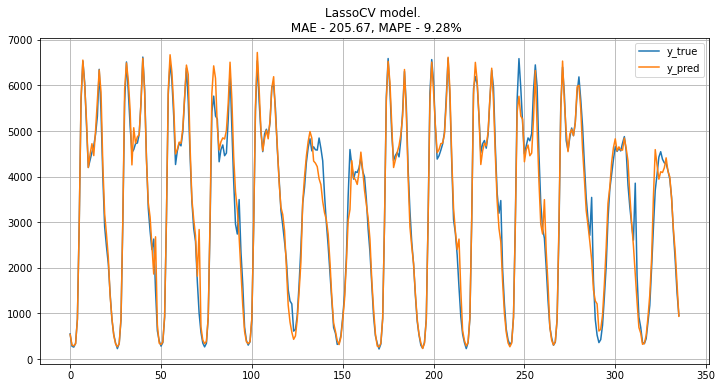

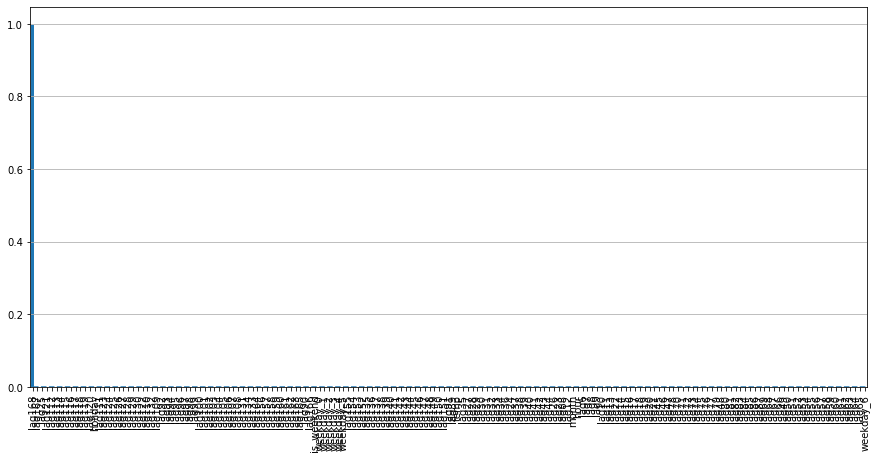

In [63]:
evaluate("LassoCV model", y_test.values, lr.predict(X_test))
plotCoefficients(lr)

#### Сработала хуже Baseline'а. Попробую применить PCA

In [64]:
from sklearn.decomposition import PCA
pca = PCA(n_components=80) # число компонент подобрано на кросс-валидации
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [65]:
pca.explained_variance_ratio_[:80].sum()

0.9953281372982598

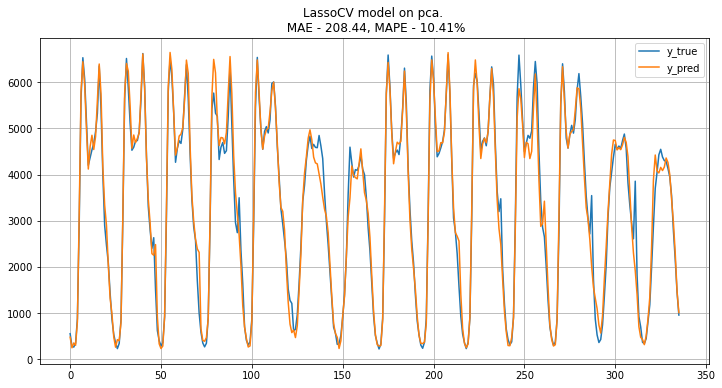

In [66]:
lr = LassoCV(cv=TimeSeriesSplit(n_splits=20), verbose=False, 
             normalize=True, selection ="random",
             max_iter=10000)

lr.fit(X_train_pca,y_train)
evaluate("LassoCV model on pca", y_test.values, lr.predict(X_test_pca))


#### Получилось даже чуть хуже

#### Xgboost

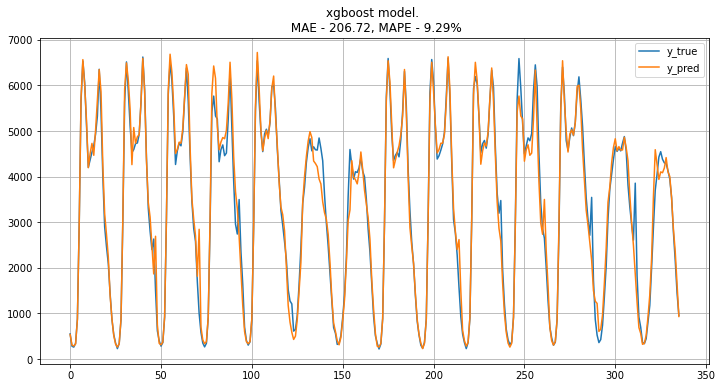

In [67]:
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
evaluate("xgboost model", y_test.values, xgb.predict(X_test))

#### Получилось на уровне Lasso

#### Prophet

In [69]:
from fbprophet import Prophet

In [70]:

predictions = 24*14

In [71]:
df = df_final.copy().rename(columns={"date_time":"ds", "traffic_volume":'y'}).loc[:,["ds","y"]]

train_df = df[:-predictions]

In [72]:
df.head()

,ds,y
0,2017-01-01 00:00:00,1848.0
1,2017-01-01 01:00:00,1806.0
2,2017-01-01 02:00:00,1211.0
3,2017-01-01 03:00:00,794.0
4,2017-01-01 04:00:00,500.0


In [73]:
%%time

model = Prophet(weekly_seasonality=True, yearly_seasonality=False, daily_seasonality=True, seasonality_mode="multiplicative")
model.fit(train_df)


future = model.make_future_dataframe(periods=predictions, freq='H', include_history=False)

forecast = model.predict(future)
forecast.tail()

Wall time: 33.2 s


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
331,2018-09-30 19:00:00,3311.318099,2176.521414,4250.543051,3304.947603,3317.135096,0.105054,0.105054,0.105054,-0.041079,-0.041079,-0.041079,-0.146133,-0.146133,-0.146133,0.0,0.0,0.0,3175.292992
332,2018-09-30 20:00:00,3311.295740,1347.041019,3510.647580,3304.896200,3317.159799,-0.115867,-0.115867,-0.115867,-0.252564,-0.252564,-0.252564,-0.136697,-0.136697,-0.136697,0.0,0.0,0.0,2474.981934
333,2018-09-30 21:00:00,3311.273382,867.703270,2997.299176,3304.844798,3317.184502,-0.265708,-0.265708,-0.265708,-0.392877,-0.392877,-0.392877,-0.127169,-0.127169,-0.127169,0.0,0.0,0.0,2010.348911
334,2018-09-30 22:00:00,3311.251023,717.308306,2763.706180,3304.793396,3317.209206,-0.362922,-0.362922,-0.362922,-0.480527,-0.480527,-0.480527,-0.117606,-0.117606,-0.117606,0.0,0.0,0.0,1720.105045
335,2018-09-30 23:00:00,3311.228665,327.698036,2512.921501,3304.741993,3317.233909,-0.473984,-0.473984,-0.473984,-0.582044,-0.582044,-0.582044,-0.108060,-0.108060,-0.108060,0.0,0.0,0.0,1383.946876


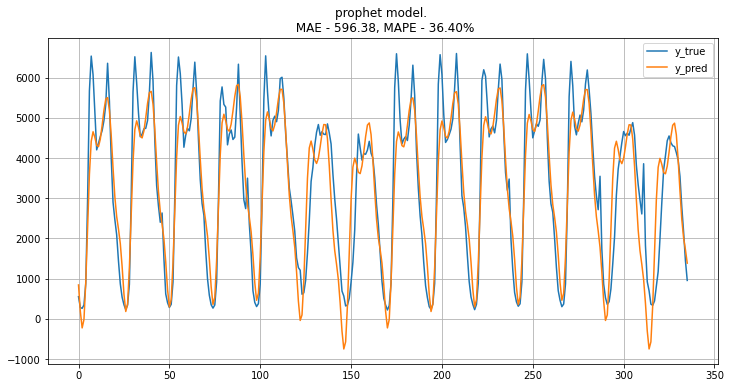

In [74]:
evaluate("prophet model", y_test.values, forecast['yhat'])

#### Совсем плохо

#### tsfresh

In [84]:
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.feature_extraction import settings

In [85]:
df = df_final.copy()
df["date"] = df.date_time.dt.date

In [86]:
df.head()

,date_time,traffic_volume,holiday,temp,month,weekday,hour,date
0,2017-01-01 00:00:00,1848.0,0.0,269.75,1,6,0,2017-01-01
1,2017-01-01 01:00:00,1806.0,0.0,269.95,1,6,1,2017-01-01
2,2017-01-01 02:00:00,1211.0,0.0,269.75,1,6,2,2017-01-01
3,2017-01-01 03:00:00,794.0,0.0,269.65,1,6,3,2017-01-01
4,2017-01-01 04:00:00,500.0,0.0,269.48,1,6,4,2017-01-01


####  попробую построить модель на базовом наборе генерируемых фич

In [87]:
days_with_features = extract_features(df, column_id="date", column_sort="date_time", column_value="traffic_volume",
                                     default_fc_parameters = settings.EfficientFCParameters())

Feature Extraction: 100%|██████████████████████| 20/20 [00:20<00:00,  1.03s/it]


In [88]:
days_with_features["target"] = pd.to_datetime(days_with_features.index.to_series()).dt.weekday


In [89]:
from tsfresh.utilities.dataframe_functions import impute
impute(days_with_features)
X = select_features(days_with_features.drop(columns="target"), days_with_features.target)
y = days_with_features.target

In [90]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
cl = RandomForestClassifier()
cl.fit(X_train, y_train)
print(classification_report(y_test, cl.predict(X_test)))

              precision    recall  f1-score   support

           0       0.59      0.81      0.68        16
           1       0.36      0.24      0.29        21
           2       0.45      0.48      0.47        21
           3       0.60      0.56      0.58        16
           4       0.91      0.95      0.93        21
           5       0.91      0.95      0.93        22
           6       1.00      0.91      0.95        11

    accuracy                           0.69       128
   macro avg       0.69      0.70      0.69       128
weighted avg       0.67      0.69      0.68       128



#### Видно,что модель неплохо отличает пятницу, субботу и воскресенье,но остальные дни для неё слишком похожи.
#### Добавлю больше переменных


In [91]:
%%time
from tsfresh.feature_extraction import settings
days_with_features = extract_features(df, column_id="date", column_sort="date_time", column_value="traffic_volume", 
                                     default_fc_parameters = settings.ComprehensiveFCParameters())
days_with_features["target"] = pd.to_datetime(days_with_features.index.to_series()).dt.weekday

impute(days_with_features)
X = select_features(days_with_features.drop(columns="target"), days_with_features.target)
y = days_with_features.target

Feature Extraction: 100%|██████████████████████| 20/20 [00:19<00:00,  1.05it/s]


Wall time: 25 s


In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
cl2 = RandomForestClassifier()
cl2.fit(X_train, y_train)
print(classification_report(y_test, cl2.predict(X_test)))

              precision    recall  f1-score   support

           0       0.74      0.77      0.76        22
           1       0.53      0.56      0.54        18
           2       0.55      0.55      0.55        20
           3       0.85      0.77      0.81        22
           4       1.00      0.92      0.96        13
           5       0.89      1.00      0.94        16
           6       0.94      0.88      0.91        17

    accuracy                           0.77       128
   macro avg       0.78      0.78      0.78       128
weighted avg       0.77      0.77      0.77       128



##### Стало лучше,но попрежнему выходные определяет точнее

## Общий вывод - для простых задач,как у нас,лучше использовать простые алгоритмы.
## На них они работают точнее